In [1]:
import os
import sys
sys.path.append("/home/dux/")
sys.path.append("/home/dux/surface_sampling/sgmc_surf")

from mcmc import mcmc_run, slab_energy

import ase
from ase.calculators.lammpsrun import LAMMPS
from ase.io import read
from ase.build import make_supercell
from catkit.gen.adsorption import get_adsorption_sites

import catkit
import numpy as np

from htvs.djangochem.pgmols.utils import surfaces

In [2]:
# Ga In N potential
# local_potential_folder = "/home/dux/surface_sampling/sgmc_surf/potentials/"
parameters = {
    'pair_style': 'meam',
    'pair_coeff': ['* * library.meam Ga In N GaN.meam Ga In N']
}
library_file = 'library.meam'
potential_file = 'GaN.meam'

lammps_calc = LAMMPS(files=[library_file, potential_file], keep_tmp_files=False, keep_alive=False, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

{'pair_style': 'meam',
 'pair_coeff': ['* * library.meam Ga In N GaN.meam Ga In N']}

In [3]:
# Get pristine surface
# GaN 0001 surface
atoms = read('GaN_hexagonal.cif')

# supercell_atoms = atoms*(2,2,2)
# supercell_atoms.write('GaN_hexagonal_2x2.cif')

supercell_atoms = atoms*(3,3,3)
supercell_atoms.write('GaN_hexagonal_3x3.cif')

# might do the opposite layer [0,0,0,1] when the stated layer in ref is [0,0,0,-1]
pristine_slab, surface_atoms = surfaces.surface_from_bulk(supercell_atoms, [0,0,0,-1], size=[3,3], vacuum=10)

# # set surface atoms from the other side
# all_atoms = np.arange(len(slab))
# curr_surf_atoms = slab.get_surface_atoms()
# new_surf_atoms = np.setdiff1d(all_atoms, curr_surf_atoms)
# slab.set_surface_atoms(new_surf_atoms)
# # invert the positions
# slab.set_scaled_positions(1 - slab.get_scaled_positions())

# slab.write('GaN_0001_2x2_pristine_slab.cif')
pristine_slab.write('GaN_neg0001_3x3_pristine_slab.cif')

/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/catkit/gen/surface.py:334: UserWarning: Your slab has no bulk atoms and may be too thin to identify surface atoms correctly. This may cause surface adsorption site identification to fail.
  warnings.warn(


In [4]:
# seems like we need at least one of each atom for potential to work
# seed random ads site with In
# read in pristine slab
# pristine_slab = read("GaN_neg0001_3x3_pristine_slab.cif")
pristine_slab.calc = lammps_calc

# get in pymatgen ads sites
all_adsorbed = read("pymatgen_GaN_neg0001_ads_Ga_all_adsorbed_slab.cif")
print(f"all adsorbed {len(all_adsorbed)}")
select_positions = all_adsorbed.get_positions()[len(pristine_slab):]

import random
random_position = random.choice(select_positions)
print(f"inserting In into random pos at {random_position}")

pristine_slab.append('In')
pristine_slab.positions[-1] = random_position

print(f"proper adsorbed energies are {pristine_slab.get_potential_energy()}")

all adsorbed 130
inserting In into random pos at [ 8.84480554  0.46422683 14.94288093]
proper adsorbed energies are -206.5084362388556


/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/ase/calculators/lammpsrun.py:379: UserWarning: semi-periodic ASE cell detected - translation to proper LAMMPS input cell might fail
  warnings.warn(


In [5]:
# canonical without relaxation
# adsorb In only for this round
element = 'In'
ads = catkit.gratoms.Gratoms(element)

# starting from more random initial positions
num_ads_atoms = 9 # this number of nitrogens on the surface

num_sweeps = 100
surface_name = "InGaN_0001_3x3"
alpha = 0.99

slab = pristine_slab.copy()
slab.write("InGaN_0001_3x3_starting_slab.cif")

# try positive chem pot
chem_pot = 5
history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_sweeps=num_sweeps, temp=1, pot=chem_pot, alpha=alpha, slab=slab, calc=lammps_calc, surface_name=surface_name, element=element, canonical=True, num_ads_atoms=num_ads_atoms, relax=False, ads_coords=select_positions)

INFO:Running with num_sweeps = 100, temp = 1, pot = 5, alpha = 0.99
INFO:there are 37 atoms 
INFO:using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7f6ddcf4de20>
/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)
INFO:In pristine sla

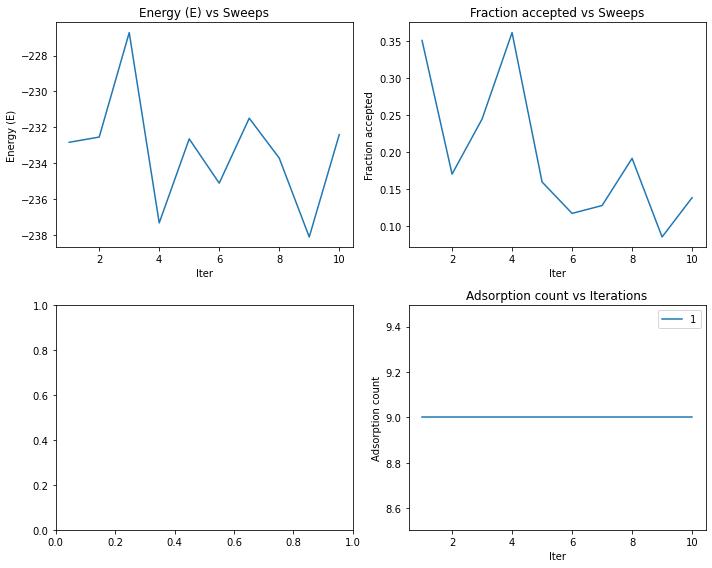

In [15]:
import matplotlib.pyplot as plt
runs = range(1, num_sweeps+1)

# do the plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()